# Can Transformer Models Detect Cyberbullying and Hate Speech in Filipino Text?

**Hypothesis 1: Tagalog-specific training data preprocessing improves performance.**

# Summary

This notebook investigated whether Tagalog-specific preprocessing methods improve hate speech detection in Filipino text. We conducted 30 independent runs comparing a baseline transformer against ten preprocessing methods using multilingual BERT (mBERT) tokenization, calamanCy Tagalog tokenizer, slang normalization, and stopword removal. The Friedman test showed significant differences among methods (with 0.05 significance level). The best method, mBERT with slang normalization and stopword removal, achieved a mean F1 score of 0.736 ($\pm 0.005$), significantly outperforming the baseline F1 of 0.724 ($\pm 0.006$) with a large effect size (Cohen's d = 1.96). Post-hoc Nemenyi tests confirmed that all four mBERT-based methods significantly outperformed the baseline. However, Tagalog-specific tokenization methods showed negative effects, with the Tagalog tokenizer reducing F1 to 0.720. Effect size analysis revealed that mBERT preprocessing provided substantial practical improvements, while calamanCy tokenization did not benefit this hate speech detection task. These results demonstrate that mBERT preprocessing improves performance, but Tagalog-specific tokenization is insufficient due to the mixed language nature of Filipino texts.

# Experimental Design

- **Methods**: 11 total (1 baseline + 10 Tagalog-specific preprocessing methods)
- **Runs**: 30 independent runs per method (330 total training sessions)
- **Metric**: Weighted F1 score
- **Statistical Tests**: Friedman test + Post-hoc Nemenyi + Cohen's d effect sizes
- **Significance Level**: $\alpha = 0.05$

# Setup

All experiments were carried out on a MacBook Pro equipped with an Apple M2 processor and 8 GB of memory.

## System Requirements

```bash
# Create and activate the virtual env
conda create -n ai351-proj python=3.10 -y
conda activate ai351-proj

# Install needed libraries
conda update -n base -c defaults conda setuptools -y
conda install -c conda-forge numpy pandas matplotlib seaborn -y
conda install -c conda-forge git -y
conda install -c conda-forge scikit-learn tensorboard -y
conda install -c conda-forge jupyter jupyterlab jupyterthemes ipython -y

# Clone the Github repo
git clone https://github.com/jedld/filipino_hate_speech_detector

# Install repo requirements
cd filipino_hate_speech_detector
pip install -U pip
pip install -r requirements.txt
pip install -U calamanCy

# Install PyTorch with Metal acceleration on Mac
conda install -c pytorch-nightly pytorch torchvision torchaudio -y

# Clear cache
conda clean -a -y
pip cache purge

# To prepare the dataset
python scripts/prepare_datasets.py --output-dir data --verbose

# To train a simple transformer model
python -m scripts.train_processed --mixed-precision --patience 10 --epochs 500

# To run a sample inference
python scripts/infer.py --text <sample_text>

# To terminate the active virtual env
conda deactivate

# To delete the virtual env
conda remove -n ai351-proj --all
```

## Run

To run the Jupyter Notebook in IDEs, ensure that ``/opt/anaconda3/envs/ai351-proj/bin/python`` is enabled as interpreter/kernel.

# Preliminary Tasks

## Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gc
import psutil

import json
import re
import random
import os
import pickle

from IPython.display import display, SVG

# Tokenizers
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from transformers import BertTokenizerFast

import calamancy

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import f1_score, precision_score, recall_score

# Statistical testing
from scipy import stats as scipy_stats
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

# Import custom model
from models.transformer import SmallTransformerClassifier

/opt/anaconda3/envs/ai351-proj/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Define constants

In [3]:
# File paths
DATASET_PATH = "./data"
MODELS_PATH = "./models"
RESULTS_PATH = "./results"

In [4]:
# Create necessary directories
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

print(f"Created directories:")
print(f"- Dataset: {DATASET_PATH}")
print(f"- Models: {MODELS_PATH}")
print(f"- Results: {RESULTS_PATH}")

Created directories:
- Dataset: ./data
- Models: ./models
- Results: ./results


In [ ]:
# Pre-processed dataset
# Prepare the dataset first by running
# python scripts/prepare_datasets.py --output-dir data --verbose
PROCESSED_TRAIN = os.path.join(DATASET_PATH, "hatespeech_filipino/processed/train.csv")
PROCESSED_VAL = os.path.join(DATASET_PATH, "hatespeech_filipino/processed/validation.csv")
PROCESSED_TEST = os.path.join(DATASET_PATH, "hatespeech_filipino/processed/test.csv")

In [6]:
# Resource file paths
SLANG_DICT_PATH = os.path.join(DATASET_PATH, "tagalog_slang_dictionary.json")
STOPWORDS_PATH = os.path.join(DATASET_PATH, "tagalog_stopwords.json")

In [ ]:
# Data preprocessing parameters
MAX_SEQ_LENGTH = 128        # Maximum sequence length for tokenization
MIN_WORD_FREQUENCY = 2      # Minimum frequency for words to be included in the vocabulary
VOCAB_SIZE = 10000          # Maximum size of the vocabulary

In [ ]:
# Transformer model parameters
EMBED_DIM = 128        # Embedding dimension for the transformer model
NUM_HEADS = 4          # Number of attention heads in the transformer
NUM_LAYERS = 2         # Number of transformer layers
NUM_CLASSES = 2        # Number of output classes
DROPOUT = 0.3          # Dropout rate for regularization

# Training hyperparameters
BATCH_SIZE = 32                 # Number of samples per training batch
LEARNING_RATE = 3e-4            # Learning rate for the optimizer
NUM_EPOCHS = 10                 # Number of training epochs
WEIGHT_DECAY = 1e-4             # Weight decay (L2 regularization) coefficient
EARLY_STOPPING_PATIENCE = 3     # Number of epochs with no improvement before stopping
LABEL_SMOOTHING = 0.1           # Label smoothing factor for regularization

In [ ]:
# Experiment parameters
N_RUNS = 30                 # Number of independent runs for statistical analysis
RANDOM_SEED_BASE = 42       # Base seed for reproducibility
SIGNIFICANCE_LEVEL = 0.05   # Alpha for statistical tests

In [10]:
# Specify which CUDA GPU to use (if available)
GPU_ID = "2,3"

# Set device as CUDA or MPS (for MacBook), if available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

if (DEVICE.type == 'cuda'):
    os.environ["CUDA_VISIBLE_DEVICES"] = GPU_ID
    print(f"CUDA Available: {torch.cuda.is_available()}")
    print(f"Using Device: {DEVICE}")
    print(f"GPU ID: {GPU_ID}")
elif (DEVICE.type == 'mps'):
    print(f"MPS available: {torch.backends.mps.is_available()}")
    print(f"Using device: {DEVICE}")
else:
    print(f"Using device: {DEVICE}")

# Verify CUDA or MPS functionality
if DEVICE.type == 'cuda':
    x = torch.randn(1, device=DEVICE)
    print(f"CUDA test successful: {x.device}")
elif DEVICE.type == 'mps':
    x = torch.randn(1, device=DEVICE)
    print(f"MPS test successful: {x.device}")

MPS available: True
Using device: mps
MPS test successful: mps:0


# Data Loading

The Filipino Hate Speech dataset from HuggingFace contains labeled text data with binary classification (0: non-hate, 1: hate speech). The dataset has already been processed and split into train, validation, and test sets.

In [ ]:
# Load the pre-processed dataset
# Prepare the dataset first by running
# python scripts/prepare_datasets.py --output-dir data --verbose
train_df = pd.read_csv(PROCESSED_TRAIN)
val_df = pd.read_csv(PROCESSED_VAL)
test_df = pd.read_csv(PROCESSED_TEST)

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"Label distribution (train): {train_df['label'].value_counts().to_dict()}")

Train set: 10000 samples
Validation set: 4232 samples
Test set: 4232 samples

Columns: ['text', 'label']
Label distribution (train): {0: 5340, 1: 4660}


In [12]:
# Check class distribution
print("Class distribution:")
print("\nTrain set:")
print(train_df['label'].value_counts())
print(f"Hate speech ratio: {train_df['label'].sum() / len(train_df):.3f}")

print("\nValidation set:")
print(val_df['label'].value_counts())
print(f"Hate speech ratio: {val_df['label'].sum() / len(val_df):.3f}")

print("\nTest set:")
print(test_df['label'].value_counts())
print(f"Hate speech ratio: {test_df['label'].sum() / len(test_df):.3f}")

Class distribution:

Train set:
label
0    5340
1    4660
Name: count, dtype: int64
Hate speech ratio: 0.466

Validation set:
label
0    2299
1    1933
Name: count, dtype: int64
Hate speech ratio: 0.457

Test set:
label
0    2225
1    2007
Name: count, dtype: int64
Hate speech ratio: 0.474


In [13]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.patch.set_facecolor('white')

splits = [('Train', train_df), ('Validation', val_df), ('Test', test_df)]
for ax, (name, df) in zip(axes, splits):
    counts = df['label'].value_counts()
    bars = ax.bar(['Non-Hate', 'Hate'], [counts[0], counts[1]], 
                   color=['#22A2E4', '#0338A6'], alpha=0.8, edgecolor='black', linewidth=1.2)
    ax.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax.set_title(f'{name} Set', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'class_distribution.pdf'), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(RESULTS_PATH, 'class_distribution.svg'), bbox_inches='tight')
plt.close()

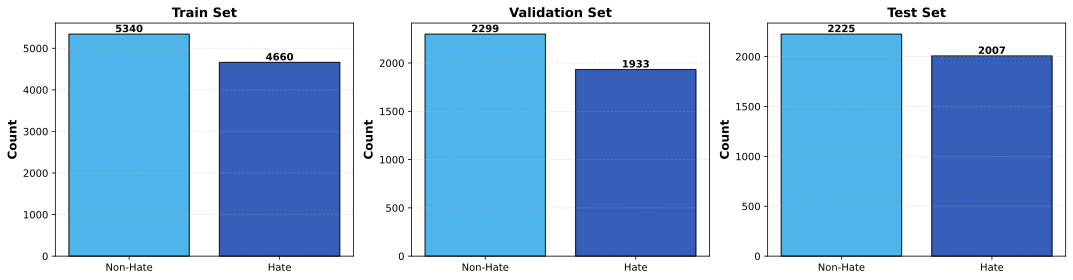

In [14]:
display(SVG(os.path.join(RESULTS_PATH, 'class_distribution.svg')))

In [ ]:
# Text length statistics
train_df['text_length'] = train_df['text'].apply(lambda x: len(str(x).split()))
val_df['text_length'] = val_df['text'].apply(lambda x: len(str(x).split()))
test_df['text_length'] = test_df['text'].apply(lambda x: len(str(x).split()))

print("\nText length statistics (words):")
print(f"Train - Mean: {train_df['text_length'].mean():.2f}, Median: {train_df['text_length'].median():.0f}, Max: {train_df['text_length'].max()}")
print(f"Val   - Mean: {val_df['text_length'].mean():.2f}, Median: {val_df['text_length'].median():.0f}, Max: {val_df['text_length'].max()}")
print(f"Test  - Mean: {test_df['text_length'].mean():.2f}, Median: {test_df['text_length'].median():.0f}, Max: {test_df['text_length'].max()}")


Text length statistics (words):
Train - Mean: 13.57, Median: 14, Max: 36
Val   - Mean: 13.66, Median: 14, Max: 31
Test  - Mean: 13.55, Median: 14, Max: 32


In [16]:
# Sample texts
print("\nSample texts:")
print("\nNon-hate examples:")
for i, row in train_df[train_df['label'] == 0].head(3).iterrows():
    print(f"  - {row['text']}")

print("\nHate speech examples:")
for i, row in train_df[train_df['label'] == 1].head(3).iterrows():
    print(f"  - {row['text']}")


Sample texts:

Non-hate examples:
  - Inaasahan na ni Vice President Jejomar Binay na may mga taong... https://t.co/SDytgbWiLh
  - Salamat sa walang sawang suporta ng mga taga makati! Ang Pagbabalik Binay In Makati #OnlyBinayInMakatiSanKaPa https://t.co/iwAOdtZPRE
  - Binay with selective amnesia, forgetting about the past six years he spent preparing to be president.  #PiliPinasDebates2016

Hate speech examples:
  - Mar Roxas TANG INA TUWID NA DAAN DAW .. EH SYA NGA DI STRAIGHT
  - @rapplerdotcom putangina mo binay TAKBO PA
  - Nognog? Pero nognog din ang nag malasakit? Wtf? Tangina mo Binay nagpapaawa kapa! Hahahahaha #Nognog ??


# Baseline Data Preprocessing

The baseline uses standard English-oriented NLP preprocessing techniques commonly applied in transformer-based models.

In [17]:
def baseline_preprocess(text):
    """
    Baseline preprocessing: URL masking, mention masking, lowercase, whitespace normalization.
    """
    text = str(text)
    
    # Mask URLs
    text = re.sub(r'https?://\S+|www\.\S+', '[URL]', text)
    
    # Mask mentions
    text = re.sub(r'@\w+', '[MENTION]', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Lowercase
    text = text.lower().strip()
    
    return text

# Test preprocessing
sample_text = train_df.iloc[0]['text']
print(f"Original: {sample_text}")
print(f"Preprocessed: {baseline_preprocess(sample_text)}")

Original: Inaasahan na ni Vice President Jejomar Binay na may mga taong... https://t.co/SDytgbWiLh
Preprocessed: inaasahan na ni vice president jejomar binay na may mga taong... [url]


In [18]:
# Apply baseline preprocessing to all datasets
train_baseline = train_df.copy()
val_baseline = val_df.copy()
test_baseline = test_df.copy()

train_baseline['text'] = train_baseline['text'].apply(baseline_preprocess)
val_baseline['text'] = val_baseline['text'].apply(baseline_preprocess)
test_baseline['text'] = test_baseline['text'].apply(baseline_preprocess)

print("Baseline preprocessing applied to all datasets")
print(f"\nExample preprocessed text:")
print(train_baseline.iloc[0]['text'])

Baseline preprocessing applied to all datasets

Example preprocessed text:
inaasahan na ni vice president jejomar binay na may mga taong... [url]


WordPiece tokenization is a subword tokenization algorithm used in BERT and other transformer models. It breaks words into smaller units to handle out-of-vocabulary words efficiently.

In [19]:
# Train WordPiece tokenizer on baseline preprocessed data
baseline_tokenizer_path = os.path.join(MODELS_PATH, "baseline_wordpiece_tokenizer.json")

if not os.path.exists(baseline_tokenizer_path):
    print("Training baseline WordPiece tokenizer...")
    
    baseline_tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
    baseline_tokenizer.pre_tokenizer = Whitespace()
    
    trainer = WordPieceTrainer(
        vocab_size=VOCAB_SIZE,
        min_frequency=MIN_WORD_FREQUENCY,
        special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "[URL]", "[MENTION]"]
    )
    
    # Train on training data
    baseline_tokenizer.train_from_iterator(
        train_baseline['text'].tolist(),
        trainer=trainer
    )
    
    # Add post-processor for BERT-style token IDs
    baseline_tokenizer.post_processor = TemplateProcessing(
        single="[CLS] $A [SEP]",
        pair="[CLS] $A [SEP] $B:1 [SEP]:1",
        special_tokens=[
            ("[CLS]", baseline_tokenizer.token_to_id("[CLS]")),
            ("[SEP]", baseline_tokenizer.token_to_id("[SEP]")),
        ],
    )
    
    # Enable padding and truncation
    baseline_tokenizer.enable_padding(pad_id=baseline_tokenizer.token_to_id("[PAD]"), 
                             pad_token="[PAD]", 
                             length=MAX_SEQ_LENGTH)
    baseline_tokenizer.enable_truncation(max_length=MAX_SEQ_LENGTH)
    
    baseline_tokenizer.save(baseline_tokenizer_path)
    print(f"Tokenizer saved to {baseline_tokenizer_path}")
else:
    baseline_tokenizer = Tokenizer.from_file(baseline_tokenizer_path)
    print(f"Loaded tokenizer from {baseline_tokenizer_path}")

print(f"Vocabulary size: {baseline_tokenizer.get_vocab_size()}")

Loaded tokenizer from ./models/baseline_wordpiece_tokenizer.json
Vocabulary size: 10000


# Tagalog Data Preprocessing Method 1: Multilingual Tokenizer

Multilingual BERT (mBERT) tokenizer is pretrained on 104 languages, including Filipino. It uses WordPiece tokenization with a vocabulary learned from multilingual corpora, which can better handle code-switching and multilingual text.

Ref: Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. arXiv preprint arXiv:1810.04805.

In [20]:
# For model training, we will use the tokenizer's encode method
# Here we just prepare the text
train_method1 = train_baseline.copy()
val_method1 = val_baseline.copy()
test_method1 = test_baseline.copy()

In [21]:
# Load mBERT tokenizer
mbert_tokenizer_path = "bert-base-multilingual-cased"

try:
    mbert_tokenizer = BertTokenizerFast.from_pretrained(mbert_tokenizer_path)
    print(f"Loaded mBERT tokenizer: {mbert_tokenizer_path}")
    print(f"Vocabulary size: {len(mbert_tokenizer)}")
except Exception as e:
    print(f"Error loading mBERT tokenizer: {e}")
    print("Will need to install transformers properly")

/opt/anaconda3/envs/ai351-proj/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded mBERT tokenizer: bert-base-multilingual-cased
Vocabulary size: 119547


In [22]:
# Apply baseline preprocessing then use mBERT tokenization
def mbert_preprocess(text: str) -> str:
    text = baseline_preprocess(text)
    tokens = mbert_tokenizer.tokenize(text)
    return ' '.join(tokens)
    
# Test tokenization
sample = "Ang Pilipinas ay maganda. The Philippines is beautiful."
tokens = mbert_preprocess(sample)
print(f"\nSample: {sample}")
print(f"Tokens: {tokens}...")


Sample: Ang Pilipinas ay maganda. The Philippines is beautiful.
Tokens: ang pili ##pina ##s ay maga ##nda . the phi ##lip ##pine ##s is beautiful ....


# Tagalog Data Preprocessing Method 2: Tagalog Tokenizer

calamanCy is a Tagalog natural language processing library built on spaCy, specifically designed for Filipino text. It provides:

1. **Lemmatization**: Reduces words to their base forms, handling Tagalog morphology
2. **Named Entity Recognition**: Identifies persons, organizations, and locations
3. **Part-of-Speech Tagging**: Tags words with Tagalog-specific grammatical categories
4. **Dependency Parsing**: Analyzes syntactic relationships in Tagalog sentences

Ref: Miranda, "calamanCy: A Tagalog Natural Language Processing Toolkit," arXiv:2109.09129, 2021.

In [ ]:
# Prepare the text for Tagalog tokenization preprocessing
train_method2 = train_baseline.copy()
val_method2 = val_baseline.copy()
test_method2 = test_baseline.copy()

In [24]:
try:
    tagalog_tokenizer = calamancy.load("tl_calamancy_md-0.2.0")
    print("Loaded calamanCy Tagalog tokenizer")
    print(f"Vocabulary size: {len(tagalog_tokenizer.vocab)}")
except ImportError:
    print("calamanCy not installed, skipping Tagalog tokenizer")
    tagalog_tokenizer = None

/opt/anaconda3/envs/ai351-proj/lib/python3.10/site-packages/spacy/util.py:977: UserWarning: [W094] Model 'tl_calamancy_md' (0.1.0) specifies an under-constrained spaCy version requirement: >=3.5.0. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.8.11,<3.9.0
  warnings.warn(warn_msg)
/opt/anaconda3/envs/ai351-proj/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Loaded calamanCy Tagalog tokenizer
Vocabulary size: 286


In [ ]:
# Apply baseline preprocessing then use Tagalog tokenization
def tagalog_tokenizer_preprocess(text: str) -> str:
    text = baseline_preprocess(text)
    if tagalog_tokenizer is not None:
        doc = tagalog_tokenizer(text)
        tokens = ' '.join([token.text for token in doc])
        return tokens
    return text
    
# Test tokenization
sample = "Ang Pilipinas ay maganda. The Philippines is beautiful."
tokens = tagalog_tokenizer_preprocess(sample)
print(f"\nSample: {sample}")
print(f"Tokens: {tokens}...")


Sample: Ang Pilipinas ay maganda. The Philippines is beautiful.
Tokens: ang pilipinas ay maganda . the philippines is beautiful ....


In [26]:
if tagalog_tokenizer is not None:
    train_method2['text'] = train_method2['text'].apply(tagalog_tokenizer_preprocess)
    val_method2['text'] = val_method2['text'].apply(tagalog_tokenizer_preprocess)
    test_method2['text'] = test_method2['text'].apply(tagalog_tokenizer_preprocess)
    print("Applied Tagalog tokenization preprocessing")

Applied Tagalog tokenization preprocessing


Train a separate WordPiece tokenizer on the Tagalog-tokenized text. This approach leverages calamanCy's linguistic knowledge for better tokenization while maintaining compatibility with the transformer model's input requirements.

Process: Text → calamanCy preprocessing (tokenization) → WordPiece tokenizer → Model

In [27]:
# Train WordPiece tokenizer on Tagalog-tokenized text
tagalog_wordpiece_path = os.path.join(MODELS_PATH, "tagalog_wordpiece_tokenizer.json")

if not os.path.exists(tagalog_wordpiece_path):
    print("Training Tagalog WordPiece tokenizer...")
    
    # Pre-tokenize training data with calamanCy
    if tagalog_tokenizer is not None:
        tagalog_pretokenized_texts = [tagalog_tokenizer_preprocess(text) for text in train_baseline['text'].tolist()]
    else:
        tagalog_pretokenized_texts = train_baseline['text'].tolist()
    
    tagalog_wordpiece = Tokenizer(WordPiece(unk_token="[UNK]"))
    tagalog_wordpiece.pre_tokenizer = Whitespace()
    
    trainer = WordPieceTrainer(
        vocab_size=VOCAB_SIZE,
        min_frequency=MIN_WORD_FREQUENCY,
        special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "[URL]", "[MENTION]"]
    )
    
    tagalog_wordpiece.train_from_iterator(
        tagalog_pretokenized_texts,
        trainer=trainer
    )
    
    tagalog_wordpiece.post_processor = TemplateProcessing(
        single="[CLS] $A [SEP]",
        pair="[CLS] $A [SEP] $B:1 [SEP]:1",
        special_tokens=[
            ("[CLS]", tagalog_wordpiece.token_to_id("[CLS]")),
            ("[SEP]", tagalog_wordpiece.token_to_id("[SEP]")),
        ],
    )
    
    tagalog_wordpiece.enable_padding(pad_id=tagalog_wordpiece.token_to_id("[PAD]"), 
                             pad_token="[PAD]", 
                             length=MAX_SEQ_LENGTH)
    tagalog_wordpiece.enable_truncation(max_length=MAX_SEQ_LENGTH)
    
    tagalog_wordpiece.save(tagalog_wordpiece_path)
    print(f"Tagalog WordPiece tokenizer saved to {tagalog_wordpiece_path}")
else:
    tagalog_wordpiece = Tokenizer.from_file(tagalog_wordpiece_path)
    print(f"Loaded Tagalog WordPiece tokenizer from {tagalog_wordpiece_path}")

print(f"Vocabulary size: {tagalog_wordpiece.get_vocab_size()}")

Loaded Tagalog WordPiece tokenizer from ./models/tagalog_wordpiece_tokenizer.json
Vocabulary size: 10000


# Tagalog Data Preprocessing Method 3: Tagalog Slang Dictionary

Filipino social media users frequently use slang, text-speak, and non-standard spellings. Tagalog slang normalization addresses the prevalence of internet slang, text-speak, and common misspellings in Filipino social media. By using a Tagalog Slang Dictionary to map these informal expressions to standard forms, we improve vocabulary consistency and reduce data sparsity.

The dictionary contains entries covering:
- Text-speak abbreviations (e.g., "kna" → "ka na")
- Common misspellings and variations
- Code-switched terms
- Internet slang specific to Filipino social media

Slang normalization has been shown to improve sentiment analysis and hate speech detection in informal text.

Ref: Han and Baldwin, "Lexical normalization of short text messages: Makn sens a #twitter," ACL, 2011.

In [28]:
# Load Tagalog Slang resource file
with open(SLANG_DICT_PATH, 'r', encoding='utf-8') as f:
    slang_data = json.load(f)
    slang_dict = slang_data['slang_mappings']

print(f"Loaded {len(slang_dict)} slang mappings")

print(f"\nSample slang mappings: {list(slang_dict.items())[:5]}")

Loaded 414 slang mappings

Sample slang mappings: [('2', 'to'), ('4', 'para'), ('aq', 'ako'), ('aqo', 'ako'), ('b', 'ba')]


In [29]:
# Define slang normalization function
def apply_slang_normalization(text, slang_dict):
    """
    Normalize Filipino slang and text-speak to standard forms.
    """
    words = text.split()
    normalized_words = [slang_dict.get(w, w) for w in words]
    return ' '.join(normalized_words)

In [30]:
# Apply slang normalization
train_method3 = train_baseline.copy()
val_method3 = val_baseline.copy()
test_method3 = test_baseline.copy()

train_method3['text'] = train_method3['text'].apply(lambda x: apply_slang_normalization(x, slang_dict))
val_method3['text'] = val_method3['text'].apply(lambda x: apply_slang_normalization(x, slang_dict))
test_method3['text'] = test_method3['text'].apply(lambda x: apply_slang_normalization(x, slang_dict))

# Tagalog Data Preprocessing Method 4: Tagalog Stopword Removal

Stopwords are common words that carry little semantic meaning. Tagalog-specific stopwords include particles and determiners unique to the language. Removing them can help the model focus on content-bearing words. However, this approach must be used carefully in hate speech detection, as some stopwords may carry contextual importance.

The Tagalog stopword list contains common function words including:
- Pronouns (ako, siya, kami)
- Particles (na, pa, nga)
- Common verbs and auxiliary words
- Question words and conjunctions

Ref: Saif et al., "On stopwords, filtering and data sparsity for sentiment analysis of Twitter," LREC, 2014.

In [31]:
# Load Tagalog Stopwords resource file
with open(STOPWORDS_PATH, 'r', encoding='utf-8') as f:
    stopwords_data = json.load(f)
    stopwords = set(stopwords_data['stopwords'])

print(f"Loaded {len(stopwords)} stopwords")

print(f"Sample stopwords: {list(stopwords)[:10]}")

Loaded 210 stopwords
Sample stopwords: ['paggawa', 'iyon', 'anumang', 'pareho', 'sabihin', 'labis', 'ginawang', 'kulang', 'tayo', 'may']


In [32]:
# Define stopword removal function
def remove_stopwords(text, stopwords):
    """
    Remove Tagalog stopwords from text.
    """
    words = text.split()
    filtered_words = [w for w in words if w not in stopwords]
    return ' '.join(filtered_words) if filtered_words else text

In [33]:
# Apply Stopword Removal
train_method4 = train_baseline.copy()
val_method4 = val_baseline.copy()
test_method4 = test_baseline.copy()

train_method4['text'] = train_method4['text'].apply(lambda x: remove_stopwords(x, stopwords))
val_method4['text'] = val_method4['text'].apply(lambda x: remove_stopwords(x, stopwords))
test_method4['text'] = test_method4['text'].apply(lambda x: remove_stopwords(x, stopwords))

# Tagalog Data Preprocessing Methods 5-10: Combinations

These methods combine multiple Tagalog-specific preprocessing techniques to evaluate their synergistic effects.

In [34]:
# Method 5: mBERT + Slang (copy from method3 which has slang); tokenization applied during training
train_method5 = train_method3.copy()
val_method5 = val_method3.copy()
test_method5 = test_method3.copy()

In [35]:
# Method 6: Tagalog Tokenizer + Slang 
train_method6 = train_method3.copy()
val_method6 = val_method3.copy()
test_method6 = test_method3.copy()

if tagalog_tokenizer is not None:
    train_method6['text'] = train_method6['text'].apply(tagalog_tokenizer_preprocess)
    val_method6['text'] = val_method6['text'].apply(tagalog_tokenizer_preprocess)
    test_method6['text'] = test_method6['text'].apply(tagalog_tokenizer_preprocess)
    print("Applied Tagalog tokenization to slang-normalized text")

Applied Tagalog tokenization to slang-normalized text


In [36]:
# Method 7: mBERT + Stopwords (copy from method4 which has stopwords); tokenization applied during training
train_method7 = train_method4.copy() 
val_method7 = val_method4.copy()
test_method7 = test_method4.copy()

In [37]:
# Method 8: Tagalog Tokenizer + Stopwords
train_method8 = train_method4.copy() 
val_method8 = val_method4.copy()
test_method8 = test_method4.copy()

if tagalog_tokenizer is not None:
    train_method8['text'] = train_method8['text'].apply(tagalog_tokenizer_preprocess)
    val_method8['text'] = val_method8['text'].apply(tagalog_tokenizer_preprocess)
    test_method8['text'] = test_method8['text'].apply(tagalog_tokenizer_preprocess)
    print("Applied Tagalog tokenization to stopword-filtered text")

Applied Tagalog tokenization to stopword-filtered text


In [38]:
# Method 9: mBERT + Slang + Stopwords
train_method9 = train_baseline.copy()
val_method9 = val_baseline.copy()
test_method9 = test_baseline.copy()

train_method9['text'] = train_method9['text'].apply(lambda x: remove_stopwords(apply_slang_normalization(x, slang_dict), stopwords))
val_method9['text'] = val_method9['text'].apply(lambda x: remove_stopwords(apply_slang_normalization(x, slang_dict), stopwords))
test_method9['text'] = test_method9['text'].apply(lambda x: remove_stopwords(apply_slang_normalization(x, slang_dict), stopwords))

In [39]:
# Method 10: Tagalog Tokenizer + Slang + Stopwords
train_method10 = train_method9.copy()
val_method10 = val_method9.copy()
test_method10 = test_method9.copy()

if tagalog_tokenizer is not None:
    train_method10['text'] = train_method10['text'].apply(tagalog_tokenizer_preprocess)
    val_method10['text'] = val_method10['text'].apply(tagalog_tokenizer_preprocess)
    test_method10['text'] = test_method10['text'].apply(tagalog_tokenizer_preprocess)
    print("Applied Tagalog tokenization to slang-normalized and stopword-filtered text")

Applied Tagalog tokenization to slang-normalized and stopword-filtered text


# Train Transformer Model

We use a simple transformer classifier with the same architecture across all preprocessing methods to ensure fair comparison. The model is designed to be lightweight yet effective for binary classification.

In [ ]:
# Main training function for single run
def train_model_single_run(train_df, val_df, test_df, tokenizer, vocab_size, is_mbert=False, seed=42):
    # Set seed for this run
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)
    
    # Create datasets
    train_dataset = HateSpeechDataset(
        train_df['text'].values,
        train_df['label'].values,
        tokenizer,
        is_mbert=is_mbert
    )
    val_dataset = HateSpeechDataset(
        val_df['text'].values,
        val_df['label'].values,
        tokenizer,
        is_mbert=is_mbert
    )
    test_dataset = HateSpeechDataset(
        test_df['text'].values,
        test_df['label'].values,
        tokenizer,
        is_mbert=is_mbert
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    model = SmallTransformerClassifier(
        vocab_size=vocab_size,
        embed_dim=EMBED_DIM,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
        num_classes=NUM_CLASSES,
        max_len=MAX_SEQ_LENGTH,
        dropout=DROPOUT
    ).to(DEVICE)
    
    # Loss with label smoothing to prevent overfitting
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    total_steps = len(train_loader) * NUM_EPOCHS
    scheduler = OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE,
        total_steps=total_steps,
        pct_start=0.15,
        anneal_strategy='cos'
    )
    
    # Training loop with early stopping
    best_val_f1 = 0
    patience_counter = 0
    
    for epoch in range(NUM_EPOCHS):
        train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer, scheduler, DEVICE)
        val_loss, val_f1, val_precision, val_recall, _, _ = evaluate(model, val_loader, criterion, DEVICE)
        
        # Save best model and early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            break
    
    # Load best model and evaluate on test set
    model.load_state_dict(best_state)
    test_loss, test_f1, test_precision, test_recall, test_preds, test_labels = evaluate(
        model, test_loader, criterion, DEVICE
    )
    
    # Clear memory
    del model, train_loader, val_loader, test_loader, best_state
    if DEVICE.type == 'cuda':
        torch.cuda.empty_cache()
    gc.collect()
    
    return {
        'test_f1': test_f1,
        'test_precision': test_precision,
        'test_recall': test_recall
    }

# Function to run multiple times and collect results
def run_multiple_experiments(method_name, train_df, val_df, test_df, tokenizer, vocab_size, is_mbert=False, n_runs=N_RUNS):
    print(f"Training {method_name} - {n_runs} independent runs")
    
    f1_scores = []
    precision_scores = []
    recall_scores = []
    
    for run_idx in range(n_runs):
        seed = RANDOM_SEED_BASE + run_idx
        print(f"\nRun {run_idx + 1}/{n_runs} (seed={seed})")
        
        result = train_model_single_run(
            train_df, val_df, test_df, 
            tokenizer, vocab_size, is_mbert, seed
        )
        
        f1_scores.append(result['test_f1'])
        precision_scores.append(result['test_precision'])
        recall_scores.append(result['test_recall'])
        
        print(f"  Test F1: {result['test_f1']:.4f}")
    
    print(f"\n{method_name} Summary (n={n_runs}):")
    print(f"  F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"  Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
    print(f"  Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
    
    return {
        'method': method_name,
        'f1_scores': f1_scores,
        'precision_scores': precision_scores,
        'recall_scores': recall_scores,
        'mean_f1': np.mean(f1_scores),
        'std_f1': np.std(f1_scores),
        'mean_precision': np.mean(precision_scores),
        'std_precision': np.std(precision_scores),
        'mean_recall': np.mean(recall_scores),
        'std_recall': np.std(recall_scores)
    }

In [41]:
# Training and evaluation functions
def train_epoch(model, loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, f1

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, f1, precision, recall, all_preds, all_labels

In [42]:
# Dataset class for hate speech classification
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, is_mbert=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.is_mbert = is_mbert
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        if self.is_mbert:
            # Use transformers tokenizer
            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=MAX_SEQ_LENGTH,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            input_ids = encoding['input_ids'].squeeze()
        else:
            # Use custom tokenizer
            encoding = self.tokenizer.encode(text)
            input_ids = torch.tensor(encoding.ids, dtype=torch.long)
        
        label = torch.tensor(label, dtype=torch.long)
        
        return input_ids, label

# Data Preprocessing Evaluation & Comparison

In [ ]:
# Run all experiments with independent runs
# Results are saved progressively after each method completes
results_path = os.path.join(RESULTS_PATH, "statistical_results.pkl")
progress_path = os.path.join(RESULTS_PATH, "progress.json")

# Load existing results if available
if os.path.exists(results_path):
    with open(results_path, 'rb') as f:
        all_results = pickle.load(f)
    print(f"Loaded existing results from {results_path}")
    print(f"Total methods completed: {len(all_results)}")
else:
    all_results = []

# Load progress to know which methods to skip
completed_methods = set()
if os.path.exists(progress_path):
    with open(progress_path, 'r') as f:
        progress = json.load(f)
        completed_methods = set(progress['completed_methods'])
        print(f"Resuming from previous run. Completed methods: {completed_methods}")

# Define all methods to run
methods_to_run = [
    ("Baseline", train_baseline, val_baseline, test_baseline, baseline_tokenizer, baseline_tokenizer.get_vocab_size(), False),
    ("mBERT", train_method1, val_method1, test_method1, mbert_tokenizer, len(mbert_tokenizer), True),
    ("Tagalog_Tok", train_method2, val_method2, test_method2, tagalog_wordpiece, tagalog_wordpiece.get_vocab_size(), False),
    ("Slang", train_method3, val_method3, test_method3, baseline_tokenizer, baseline_tokenizer.get_vocab_size(), False),
    ("Stopwords", train_method4, val_method4, test_method4, baseline_tokenizer, baseline_tokenizer.get_vocab_size(), False),
    ("mBERT_Slang", train_method5, val_method5, test_method5, mbert_tokenizer, len(mbert_tokenizer), True),
    ("TagTok_Slang", train_method6, val_method6, test_method6, tagalog_wordpiece, tagalog_wordpiece.get_vocab_size(), False),
    ("mBERT_Stop", train_method7, val_method7, test_method7, mbert_tokenizer, len(mbert_tokenizer), True),
    ("TagTok_Stop", train_method8, val_method8, test_method8, tagalog_wordpiece, tagalog_wordpiece.get_vocab_size(), False),
    ("mBERT_Slang_Stop", train_method9, val_method9, test_method9, mbert_tokenizer, len(mbert_tokenizer), True),
    ("TagTok_Slang_Stop", train_method10, val_method10, test_method10, tagalog_wordpiece, tagalog_wordpiece.get_vocab_size(), False),
]

print(f"Starting Statistical Experiment: {N_RUNS} runs x {len(methods_to_run)} methods = {N_RUNS * len(methods_to_run)} total runs")

for method_name, train_df, val_df, test_df, tokenizer, vocab_size, is_mbert in methods_to_run:
    if method_name in completed_methods:
        print(f"\n[SKIP] {method_name} - already completed")
        continue
    
    try:
        result = run_multiple_experiments(
            method_name, train_df, val_df, test_df, 
            tokenizer, vocab_size, is_mbert
        )
        all_results.append(result)
        completed_methods.add(method_name)
        
        # Save progress after each method
        with open(results_path, 'wb') as f:
            pickle.dump(all_results, f)
        with open(progress_path, 'w') as f:
            json.dump({'completed_methods': list(completed_methods)}, f)
        
        print(f"\nProgress saved: {len(completed_methods)}/{len(methods_to_run)} methods completed")
        
    except KeyboardInterrupt:
        print(f"\n\nInterrupted! Saving progress...")
        with open(results_path, 'wb') as f:
            pickle.dump(all_results, f)
        with open(progress_path, 'w') as f:
            json.dump({'completed_methods': list(completed_methods)}, f)
        print(f"Progress saved. {len(completed_methods)}/{len(methods_to_run)} methods completed")
        print("Run this cell again to resume from where you left off.")
        raise

print(f"ALL EXPERIMENTS COMPLETED!")
print(f"Results saved to {results_path}")

Loaded existing results from ./results/statistical_results.pkl
Total methods completed: 11
Resuming from previous run. Completed methods: {'mBERT', 'TagTok_Slang', 'TagTok_Slang_Stop', 'Slang', 'Baseline', 'TagTok_Stop', 'mBERT_Slang_Stop', 'Stopwords', 'Tagalog_Tok', 'mBERT_Stop', 'mBERT_Slang'}
Starting Statistical Experiment: 30 runs x 11 methods = 330 total runs

[SKIP] Baseline - already completed

[SKIP] mBERT - already completed

[SKIP] Tagalog_Tok - already completed

[SKIP] Slang - already completed

[SKIP] Stopwords - already completed

[SKIP] mBERT_Slang - already completed

[SKIP] TagTok_Slang - already completed

[SKIP] mBERT_Stop - already completed

[SKIP] TagTok_Stop - already completed

[SKIP] mBERT_Slang_Stop - already completed

[SKIP] TagTok_Slang_Stop - already completed
ALL EXPERIMENTS COMPLETED!
Results saved to ./results/statistical_results.pkl


In [44]:
# Create summary dataframe
summary_data = []
for r in all_results:
    summary_data.append({
        'Method': r['method'],
        'Mean F1': r['mean_f1'],
        'Std F1': r['std_f1'],
        'Mean Precision': r['mean_precision'],
        'Std Precision': r['std_precision'],
        'Mean Recall': r['mean_recall'],
        'Std Recall': r['std_recall']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Mean F1', ascending=False).reset_index(drop=True)

print("\nPerformance Summary (sorted by mean F1 score):")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv(os.path.join(RESULTS_PATH, 'performance_summary_30runs.csv'), index=False)
print(f"\nSummary saved to {RESULTS_PATH}/performance_summary_30runs.csv")


Performance Summary (sorted by mean F1 score):
           Method  Mean F1   Std F1  Mean Precision  Std Precision  Mean Recall  Std Recall
 mBERT_Slang_Stop 0.735685 0.004943        0.739342       0.004820     0.737413    0.004723
       mBERT_Stop 0.734825 0.005058        0.738515       0.005552     0.736586    0.005094
            mBERT 0.734555 0.004726        0.737847       0.005483     0.736122    0.004806
      mBERT_Slang 0.734113 0.004935        0.738159       0.005734     0.735948    0.005067
            Slang 0.725802 0.005835        0.729294       0.005873     0.727536    0.005574
         Baseline 0.724481 0.006218        0.728265       0.006122     0.726347    0.005923
        Stopwords 0.723539 0.007289        0.728042       0.006974     0.725693    0.006959
     TagTok_Slang 0.721391 0.004721        0.724933       0.004855     0.723196    0.004594
TagTok_Slang_Stop 0.720814 0.006002        0.724400       0.006173     0.722637    0.005907
      Tagalog_Tok 0.720391 0.005

# Statistical Analysis

We perform rigorous statistical tests to determine whether the preprocessing methods significantly differ from the baseline approach.

## Friedman Test

The Friedman test is a non-parametric statistical test used to detect differences in treatments across multiple test attempts. It is the non-parametric alternative to repeated measures ANOVA and is appropriate when the assumptions of normality are not met.

The null hypothesis is that all methods have the same distribution of F1 scores. We use a significance level of $\alpha = 0.05$.

In [45]:
# Prepare data for Friedman test
# Shape: (n_runs, n_methods)
f1_matrix = np.array([r['f1_scores'] for r in all_results]).T
print(f"F1 score matrix shape: {f1_matrix.shape}")
print(f"(rows: runs, columns: methods)")

# Perform Friedman test
statistic, p_value = friedmanchisquare(*f1_matrix.T)

print(f"\nFriedman Test Results:")
print(f"  Statistic: {statistic:.4f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Significance level: {SIGNIFICANCE_LEVEL}")

if p_value < SIGNIFICANCE_LEVEL:
    print(f"\nResult: SIGNIFICANT (p < {SIGNIFICANCE_LEVEL})")
    print(f"  The null hypothesis is rejected.")
    print(f"  At least one method differs significantly from others.")
else:
    print(f"\nResult: NOT SIGNIFICANT (p >= {SIGNIFICANCE_LEVEL})")
    print(f"  The null hypothesis cannot be rejected.")
    print(f"  No significant difference detected among methods.")

F1 score matrix shape: (30, 11)
(rows: runs, columns: methods)

Friedman Test Results:
  Statistic: 167.0182
  P-value: 0.000000
  Significance level: 0.05

Result: SIGNIFICANT (p < 0.05)
  The null hypothesis is rejected.
  At least one method differs significantly from others.


## Post-hoc Nemenyi Test

If the Friedman test is significant, we perform post-hoc pairwise comparisons using the Nemenyi test. This test controls for multiple comparisons and identifies which specific methods differ from each other.

The Nemenyi test computes critical distances to determine significant differences between method pairs based on their average ranks.

In [46]:
# Post-hoc Nemenyi test (only if Friedman test is significant)
if p_value < SIGNIFICANCE_LEVEL:
    print("Performing Post-hoc Nemenyi test...")
    
    # Create DataFrame for posthoc test
    f1_df = pd.DataFrame(f1_matrix, columns=[r['method'] for r in all_results])
    
    # Perform Nemenyi test
    nemenyi_result = sp.posthoc_nemenyi_friedman(f1_df)
    
    print("\nNemenyi Test P-values (pairwise comparisons):")
    print(nemenyi_result.to_string())
    
    # Save Nemenyi results
    nemenyi_result.to_csv(os.path.join(RESULTS_PATH, 'nemenyi_pvalues.csv'))
    print(f"\nNemenyi p-values saved to {RESULTS_PATH}/nemenyi_pvalues.csv")
    
    # Extract comparisons with baseline
    baseline_method = all_results[0]['method']
    print(f"\n\nComparisons with {baseline_method}:")
    print(f"{'Method':<25} {'P-value':<12} {'Significant?':<15}")
    print("-" * 55)
    
    for method in nemenyi_result.index:
        if method != baseline_method:
            p_val = nemenyi_result.loc[method, baseline_method]
            is_sig = "Yes" if p_val < SIGNIFICANCE_LEVEL else "No"
            print(f"{method:<25} {p_val:<12.6f} {is_sig:<15}")
else:
    print("\nSkipping Post-hoc tests (Friedman test was not significant)")

Performing Post-hoc Nemenyi test...

Nemenyi Test P-values (pairwise comparisons):
                   Baseline         mBERT   Tagalog_Tok     Slang  Stopwords   mBERT_Slang  TagTok_Slang    mBERT_Stop   TagTok_Stop  mBERT_Slang_Stop  TagTok_Slang_Stop
Baseline           1.000000  2.972996e-03  6.594703e-01  0.999935   0.999935  2.746893e-04  8.675571e-01  6.680709e-04  4.912448e-01      1.084066e-04       9.000721e-01
mBERT              0.002973  1.000000e+00  1.119106e-07  0.029392   0.000190  9.999813e-01  9.066502e-07  9.999997e-01  2.593006e-08      9.996875e-01       1.419481e-06
Tagalog_Tok        0.659470  1.119106e-07  1.000000e+00  0.244328   0.957297  3.393771e-09  9.999997e-01  1.223200e-08  1.000000e+00      9.071315e-10       9.999981e-01
Slang              0.999935  2.939225e-02  2.443275e-01  1.000000   0.977215  4.063570e-03  4.634693e-01  8.597451e-03  1.424754e-01      1.835874e-03       5.193251e-01
Stopwords          0.999935  1.903010e-04  9.572966e-01  0.977215  

## Effect Size Calculation

Effect sizes quantify the practical significance of differences between methods, complementing p-values which only indicate statistical significance. We use Cohen's d, which measures the standardized difference between two means.

Cohen's d interpretation:
- Negligible effect: $d < 0.2$
- Small effect: $0.2 \leq d < 0.5$
- Medium effect: $0.5 \leq d < 0.8$
- Large effect: $d \geq 0.8$

In [47]:
# Calculate Cohen's d effect sizes compared to baseline
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

baseline_f1 = all_results[0]['f1_scores']
baseline_method = all_results[0]['method']

effect_sizes = []
print(f"Effect Sizes (Cohen's d) compared to {baseline_method}:")
print(f"{'Method':<25} {'Mean Diff':<12} {'Cohens d':<12} {'Effect Size':<15}")
print("-" * 70)

for r in all_results:
    if r['method'] != baseline_method:
        method_f1 = r['f1_scores']
        d = cohens_d(method_f1, baseline_f1)
        mean_diff = r['mean_f1'] - all_results[0]['mean_f1']
        
        # Interpret effect size
        if abs(d) < 0.2:
            interpretation = "Negligible"
        elif abs(d) < 0.5:
            interpretation = "Small"
        elif abs(d) < 0.8:
            interpretation = "Medium"
        else:
            interpretation = "Large"
        
        effect_sizes.append({
            'Method': r['method'],
            'Mean_Diff': mean_diff,
            'Cohens_d': d,
            'Effect_Size': interpretation
        })
        
        print(f"{r['method']:<25} {mean_diff:>+11.4f} {d:>+11.3f} {interpretation:<15}")

# Save effect sizes
effect_df = pd.DataFrame(effect_sizes)
effect_df.to_csv(os.path.join(RESULTS_PATH, 'effect_sizes.csv'), index=False)
print(f"\nEffect sizes saved to {RESULTS_PATH}/effect_sizes.csv")

Effect Sizes (Cohen's d) compared to Baseline:
Method                    Mean Diff    Cohens d     Effect Size    
----------------------------------------------------------------------
mBERT                         +0.0101      +1.793 Large          
Tagalog_Tok                   -0.0041      -0.681 Medium         
Slang                         +0.0013      +0.215 Small          
Stopwords                     -0.0009      -0.137 Negligible     
mBERT_Slang                   +0.0096      +1.687 Large          
TagTok_Slang                  -0.0031      -0.550 Medium         
mBERT_Stop                    +0.0103      +1.794 Large          
TagTok_Stop                   -0.0048      -0.803 Large          
mBERT_Slang_Stop              +0.0112      +1.961 Large          
TagTok_Slang_Stop             -0.0037      -0.590 Medium         

Effect sizes saved to ./results/effect_sizes.csv


Mean F1 scores with 95% CI plot saved
X-axis range: 0.7127 to 0.7426


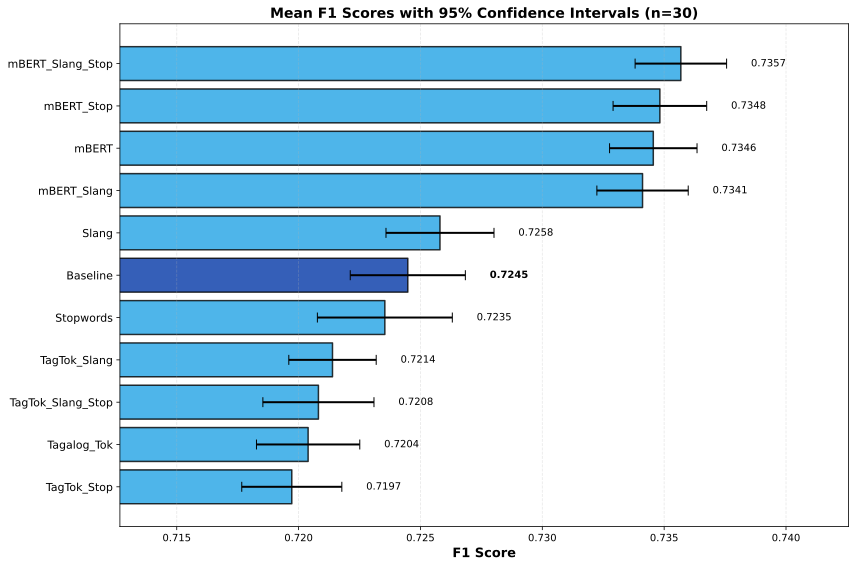

In [ ]:
# Calculate 95% confidence intervals
ci_data = []
for r in all_results:
    f1_scores = r['f1_scores']
    mean = np.mean(f1_scores)
    std_err = scipy_stats.sem(f1_scores)
    ci = scipy_stats.t.interval(0.95, len(f1_scores)-1, loc=mean, scale=std_err)
    ci_data.append({
        'Method': r['method'],
        'Mean': mean,
        'CI_Lower': ci[0],
        'CI_Upper': ci[1],
        'CI_Width': ci[1] - ci[0]
    })

ci_df = pd.DataFrame(ci_data)
ci_df = ci_df.sort_values('Mean', ascending=True)

# Plot mean F1 with 95% CI - zoomed to show differences
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('white')

y_pos = np.arange(len(ci_df))
means = ci_df['Mean'].values
ci_lower = ci_df['CI_Lower'].values
ci_upper = ci_df['CI_Upper'].values
errors = np.array([means - ci_lower, ci_upper - means])

# Highlight baseline
colors = ['#0338A6' if method == baseline_method else '#22A2E4' for method in ci_df['Method']]

bars = ax.barh(y_pos, means, xerr=errors, color=colors, alpha=0.8, 
               edgecolor='black', linewidth=1.5, capsize=5, error_kw={'linewidth': 2})

ax.set_yticks(y_pos)
ax.set_yticklabels(ci_df['Method'], fontsize=11)
ax.set_xlabel('F1 Score', fontsize=13, fontweight='bold')
ax.set_title(f"Mean F1 Scores with 95% Confidence Intervals (n={N_RUNS})", fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Zoom x-axis to actual data range for better visibility
x_min = ci_df['CI_Lower'].min() - 0.005
x_max = ci_df['CI_Upper'].max() + 0.005
ax.set_xlim(x_min, x_max)

# Add value labels
for i, (idx, row) in enumerate(ci_df.iterrows()):
    weight = 'bold' if row['Method'] == baseline_method else 'normal'
    # Position label outside the bar for clarity
    label_x = row['CI_Upper'] + 0.001
    ax.text(label_x, i, f"{row['Mean']:.4f}", 
            va='center', fontweight=weight, fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'mean_f1_with_ci.pdf'), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(RESULTS_PATH, 'mean_f1_with_ci.svg'), bbox_inches='tight')
plt.close()

print("Mean F1 scores with 95% CI plot saved")
print(f"X-axis range: {x_min:.4f} to {x_max:.4f}")
display(SVG(os.path.join(RESULTS_PATH, 'mean_f1_with_ci.svg')))

# Analysis and Discussion

## Overall Results

The experiment tested 11 preprocessing methods across 30 independent runs. The Friedman test confirmed significant differences among methods ($\chi^2 = 167.02$, $p < 0.05$), rejecting the null hypothesis that all methods perform equally.

## Performance Rankings

Methods ranked by mean F1 score:

1. **mBERT_Slang_Stop**: $0.736 \pm 0.005$ - Best performer
2. **mBERT_Stop**: $0.735 \pm 0.005$
3. **mBERT**: $0.735 \pm 0.005$
4. **mBERT_Slang**: $0.734 \pm 0.005$
5. **Slang**: $0.726 \pm 0.006$
6. **Baseline**: $0.724 \pm 0.006$
7. **Stopwords**: $0.724 \pm 0.007$
8. **TagTok_Slang**: $0.721 \pm 0.005$
9. **TagTok_Slang_Stop**: $0.721 \pm 0.006$
10. **Tagalog_Tok**: $0.720 \pm 0.006$
11. **TagTok_Stop**: $0.720 \pm 0.005$

## Statistical Significance

Post-hoc Nemenyi tests revealed that four mBERT-based methods significantly outperformed the baseline (all $p < 0.05$):

- mBERT_Slang_Stop vs Baseline: $p = 0.0001$
- mBERT_Stop vs Baseline: $p = 0.0007$
- mBERT vs Baseline: $p = 0.003$
- mBERT_Slang vs Baseline: $p = 0.0003$

All Tagalog tokenizer methods performed worse than baseline, though not all differences were statistically significant.

## Effect Sizes

Cohen's d values showed practical significance versus the baseline:

**Large positive effects ($d > 0.8$):**
- mBERT_Slang_Stop: $d = 1.96$
- mBERT_Stop: $d = 1.79$
- mBERT: $d = 1.79$
- mBERT_Slang: $d = 1.69$

**Medium to large negative effects:**
- TagTok_Stop: $d = -0.80$
- Tagalog_Tok: $d = -0.68$
- TagTok_Slang_Stop: $d = -0.59$
- TagTok_Slang: $d = -0.55$

**Small or negligible effects:**
- Slang: $d = 0.22$
- Stopwords: $d = -0.14$

## Findings

**mBERT preprocessing works:** All four methods using multilingual BERT tokenization significantly improved F1 scores. The combination with slang normalization and stopword removal achieved the best results.

**Tagalog tokenization hurts performance:** Despite being linguistically motivated, calamanCy tokenization reduced performance. This suggests that the linguistic structure captured by calamanCy does not align well with hate speech patterns, or that the simple transformer model could not leverage this information effectively.

**Slang normalization helps slightly:** When applied alone, slang normalization showed a small positive effect ($d = 0.22$) but did not reach statistical significance.

**Stopword removal has minimal impact:** Removing Tagalog stopwords showed negligible effects when applied alone.

**Combinations matter:** mBERT combined with preprocessing techniques performed better than mBERT alone, though the gains were modest.

## Why mBERT Succeeds while Tagalog Tokenization Fails

Multilingual BERT's success comes from:

- **Multilingual representations:** From massive pretraining, mBERT captures cross-lingual semantic patterns that are common in Filipino texts.
- **Subword tokenization:** WordPiece handles morphological variations and code-switching common in Filipino social media.

The poor performance of calamanCy-based methods likely stems from:

- **Domain mismatch:** calamanCy was trained on formal Tagalog text, while hate speech uses informal, mixed language.
- **No pretrained embeddings:** Tagalog tokenization provides only surface-level segmentation without semantic content.

# Conclusion

This experiment tested whether Tagalog-specific preprocessing improves hate speech detection in Filipino text. Some preprocessing helps, but not all.

Multilingual BERT (mBERT) tokenization significantly improved performance, achieving F1 scores around 0.735 compared to the baseline 0.724. The best method combined mBERT with slang normalization and stopword removal (F1 = 0.736). Statistical tests confirmed these improvements were significant with large effect sizes (Cohen's d = 1.8-2.0).

Tagalog-specific tokenization using calamanCy, however, harmed performance. All methods using the Tagalog tokenizer scored below baseline (F1 = 0.720), showing that linguistic tokenization alone does not help without pretrained contextual embeddings.

## Limitations

**Hardware constraints:** Experiments ran on an M2 MacBook with 8GB RAM, limiting model size and batch sizes. Larger transformers or longer sequences might show different patterns.

**Dataset specificity:** Results apply to the Filipino Hate Speech dataset from social media. Performance on formal text or other Filipino languages may differ.

**Model architecture:** We used a small 2-layer transformer. Larger models might better leverage linguistic tokenization.

**Slang dictionary and stopword list:** Limited slang dictionary and stopword list entries (around 200 only). Building larger dictionaries from big Filipino social media corpora may help.

**Error analysis:** Qualitative analysis of misclassified instances can be done to understand failure modes.

# Cleanup

In [50]:
# Final memory cleanup
variables_to_delete = [
    'train_df', 'val_df', 'test_df',
    'train_baseline', 'val_baseline', 'test_baseline',
    'train_method1', 'val_method1', 'test_method1',
    'train_method2', 'val_method2', 'test_method2',
    'train_method3', 'val_method3', 'test_method3',
    'train_method4', 'val_method4', 'test_method4',
    'train_method5', 'val_method5', 'test_method5',
    'train_method6', 'val_method6', 'test_method6',
    'train_method7', 'val_method7', 'test_method7',
    'train_method8', 'val_method8', 'test_method8',
    'train_method9', 'val_method9', 'test_method9',
    'train_method10', 'val_method10', 'test_method10',
    'baseline_tokenizer', 'mbert_tokenizer', 'tagalog_tokenizer',
    'slang_dict', 'stopwords'
]

for var_name in variables_to_delete:
    if var_name in globals():
        del globals()[var_name]
        print(f"Deleted: {var_name}")

if DEVICE.type == 'cuda':
    torch.cuda.empty_cache()
    print("CUDA cache cleared")

gc.collect()

memory_percent = psutil.virtual_memory().percent
print(f"\nCurrent memory usage: {memory_percent:.1f}%")
print(f"Cleanup completed successfully!")

Deleted: train_df
Deleted: val_df
Deleted: test_df
Deleted: train_baseline
Deleted: val_baseline
Deleted: test_baseline
Deleted: train_method1
Deleted: val_method1
Deleted: test_method1
Deleted: train_method2
Deleted: val_method2
Deleted: test_method2
Deleted: train_method3
Deleted: val_method3
Deleted: test_method3
Deleted: train_method4
Deleted: val_method4
Deleted: test_method4
Deleted: train_method5
Deleted: val_method5
Deleted: test_method5
Deleted: train_method6
Deleted: val_method6
Deleted: test_method6
Deleted: train_method7
Deleted: val_method7
Deleted: test_method7
Deleted: train_method8
Deleted: val_method8
Deleted: test_method8
Deleted: train_method9
Deleted: val_method9
Deleted: test_method9
Deleted: train_method10
Deleted: val_method10
Deleted: test_method10
Deleted: baseline_tokenizer
Deleted: mbert_tokenizer
Deleted: tagalog_tokenizer
Deleted: slang_dict
Deleted: stopwords

Current memory usage: 81.3%
Cleanup completed successfully!
